# Build master(merged) data from the three raw data files

In [1]:
%load_ext autoreload
%autoreload 2


from ecoindex.pipeline import make_interim
from ecoindex.data_io import load_interim

make_interim()  # reads Excel -> cleans -> writes to data/interim/

taxa = load_interim("taxa_clean.parquet")
chem = load_interim("chem_clean.parquet")
env  = load_interim("env_clean.parquet")

from ecoindex.dataframe_ops import wrap_columns, add_site_block, concat_blocks, flatten_columns, get_block, align_blocks_by_index
from ecoindex.transform import hellinger_transform, log1p_standardize

# 1) Your three clean site-level tables (indexed by StationID)
taxa = taxa.set_index("StationID").sort_index()
chem = chem.set_index("StationID").sort_index()
env  = env.set_index("StationID").sort_index()

## (a) Strict intersection (keep only sites in all three)
taxa, chem, env = align_blocks_by_index([taxa, chem, env], how="inner")

# 2) Wrap each into a clear block
taxa_wrapped = wrap_columns(taxa, "taxa", "raw")
chem_wrapped   = wrap_columns(chem, "chemical", "raw")
env_wrapped   = wrap_columns(env, "environmental", "raw")  # no subblockb

# 3) Build master from blocks
master = concat_blocks([taxa_wrapped, chem_wrapped, env_wrapped])

# Apply hellinger transformation on the raw taxa data
taxa_hell = hellinger_transform(get_block(master, "taxa", "raw"))
# Wrap and add the transformed data into the 'taxa' block with 'hellinger' subblock
master = add_site_block(master, taxa_hell, "taxa", "hellinger")

# Do similar work to logarithmic transformation on the raw chemical data
chem_logz = log1p_standardize(get_block(master, "chemical", "raw"))
master = add_site_block(master, chem_logz, "chemical", "logz")

master.head()

block      chemical                                                          \
subblock        raw                                                           
var         1234TCB   1245TCB     Al     As        Bi     Ca      Cd     Co   
StationID                                                                     
A10        0.835583  0.775732   3041  1.939  18.45000  28170  0.2950  2.723   
A23        0.639983  0.697265   4483  2.512  17.03000  42110  0.3986  4.009   
A27        0.451838  0.815149  13620  2.759   0.05370  41610  0.2180  6.273   
A28        0.224379  0.483363  12750  2.609   0.06617  33280  0.1197  5.824   
A29        0.299715  0.695356  23740  3.735   0.15290  40450  0.1536  9.618   

block                     ...                                          \
subblock                  ...      logz                                 
var            Cr     Cu  ...       OCS        Pb       QCB        Sb   
StationID                 ...                                           
A10         8.766  17.64  ... -0.312165  0.280413 -0.737303  0.703623   
A23        10.850  17.28  ... -0.687740 -0.023640  0.328420 -0.117357   
A27        21.080  25.00  ... -0.123819  0.006849 -0.756687 -1.917417   
A28        18.700  24.07  ... -0.483904 -0.088969 -0.570351 -1.917417   
A29        44.370  44.72  ...  0.223999  0.703332 -0.343399 -1.831041   

block                                                                  
subblock                                                               
var               V        Zn     mirex     ppDDD     ppDDE total_PCB  
StationID                                                              
A10       -0.289330  0.099916 -0.593026 -0.190979 -0.343200 -0.397416  
A23       -0.041387  0.190802  0.111417  0.077590  0.137696  0.365410  
A27        1.440670  0.683376  1.056451  0.868995  0.149458  0.442485  
A28        1.212692  0.578433 -0.593026  0.894114  0.404618 -0.504533  
A29        2.455776  1.536552  2.136226 -0.366882  0.230192  0.256692  

[5 rows x 99 columns]

# PCA assessment on stressor data with comprehensive chemical weights

## weigted PCA assessment of chemical data

In [2]:
from ecoindex import pca_assessment
import pandas as pd

# import the chemical weights configuration
from ecoindex.chemical_weights import (
    build_weights_for_columns,
    VARIABLE_TYPE_BY_NAME, # default mapping of variable name to type
    TYPE_WEIGHTS,
    configure_type_weights,
)

# Columns in use for the PCA call above
chem_cols = pca_assessment.get_block(master, "chemical", "logz").columns

# specify custom weights for certain types (others will use defaults)
type_weights = {
    "Trace Metal (pollutant)": 3.0,
    "Trace Metal_Sb (pollutant)": 3.0,  # Highest priority: toxic metals
    "Trace Metal_Bi (pollutant)": 3.0,  # Highest priority: toxic metals
    "Hydrocarbon pollutant": 3.0,        # Highest priority: petroleum/chlorobenzenes
    "organochlorine pesticide": 3.0,     # Highest priority: POPs
    "Sum of all PCBs": 10.0,              # Highest priority: PCBs
    "Binding agent": 3.0,               # Medium priority: affects bioavailability
    "Earth element (nontoxic)": 3   # Lowest priority: background elements
}

# Build the final weight map for the variables for later use in weighted PCA
custom_weight_map = build_weights_for_columns(chem_cols, 
                                              type_weights=type_weights,
                                              weights_by_name={"1245TCB": 3})

# Run PCA with weights applied
result_weighted = pca_assessment.pca_chemical_assessment(
    master,
    chemical_block="chemical",
    subblock="logz",
    standardize=False,
    apply_weights=True,
    custom_weights=custom_weight_map,
)

result_weighted.loadings.head()

Applied variable weights - >=3.0: 30 vars, 2.0-<3.0: 0 vars, < 2.0: 0 vars, =1.0: 0 vars


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
var,,,,,,,,,,,,,,,,,,,,,
1234TCB,0.059347,-0.013679,0.025943,0.249263,0.076113,0.587150,-0.600242,0.076818,0.317693,0.116378,...,-0.094765,-0.074903,-0.025910,-0.012214,0.023314,-0.012655,0.034272,-0.024066,0.015088,-0.008231
1245TCB,0.106370,0.360947,-0.028974,-0.191317,-0.149021,-0.053983,-0.047451,-0.033000,0.094034,-0.099742,...,-0.407357,0.041532,0.019428,-0.092822,-0.169378,-0.015428,0.086686,0.021980,0.009888,-0.050958
Al,0.226942,-0.083969,-0.213664,0.032287,-0.146542,0.005468,0.036446,-0.186714,-0.056058,0.125435,...,-0.155636,-0.091544,0.123834,-0.246702,-0.009446,0.025021,-0.119417,-0.199670,0.438869,0.638774
As,0.125745,-0.158486,-0.027379,-0.216191,-0.004684,-0.112826,0.163754,0.326078,0.665266,-0.058613,...,-0.039259,-0.018308,0.098641,-0.123928,0.183806,0.024570,-0.056790,-0.103279,-0.001407,-0.010996
Bi,-0.139000,0.252714,-0.084988,0.315514,0.076178,-0.166684,0.032146,-0.145964,0.269929,0.374504,...,0.008228,0.109620,0.146091,0.123179,-0.147222,-0.009768,-0.602184,0.159561,-0.107591,0.041374


In [3]:
# Preview: variable -> (type, custom_w) for the first 10 variables
names = list(chem_cols)[:10]
rows = []
for name in names:
    vtype = VARIABLE_TYPE_BY_NAME.get(name, "Unclassified")
    w_cus = custom_weight_map.get(name, 1.0)
    rows.append((name, vtype, w_cus))
preview_df = pd.DataFrame(rows, columns=["variable", "type", "custom_w"])
print(preview_df)

  variable                        type  custom_w
0  1234TCB       Hydrocarbon pollutant       3.0
1  1245TCB       Hydrocarbon pollutant       3.0
2       Al    Earth element (nontoxic)       3.0
3       As     Trace Metal (pollutant)       3.0
4       Bi  Trace Metal_Bi (pollutant)       3.0
5       Ca    Earth element (nontoxic)       3.0
6       Cd     Trace Metal (pollutant)       3.0
7       Co     Trace Metal (pollutant)       3.0
8       Cr     Trace Metal (pollutant)       3.0
9       Cu     Trace Metal (pollutant)       3.0


## Filter PCs by considering ratios of high-weighted variables over high-loading variables

In [4]:
# Select PCs dominated by high-weight variables
from ecoindex import pca_assessment

selection_pos = pca_assessment.select_pcs_by_weighted_loadings(
    result_weighted,
    high_weight_threshold=2,
    loading_threshold=0.2,
    top_k_variables_per_pc=10,
    prefer_positive=True,
)

filtered_pcs = selection_pos["selected_pcs"]
print(f"Total explained variance: {selection_pos['cumulative_explained_variance']}")
filtered_pcs

Total explained variance: 0.9699431024842365


['PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC8',
 'PC9',
 'PC10',
 'PC11',
 'PC12',
 'PC13',
 'PC14',
 'PC15',
 'PC16',
 'PC17',
 'PC18',
 'PC19',
 'PC20',
 'PC21',
 'PC22',
 'PC23',
 'PC24',
 'PC25',
 'PC26',
 'PC28',
 'PC29',
 'PC30']

## Compute pollution scores with selected PCs

In [5]:
from ecoindex.pca_assessment import compute_pollution_scores_with_labels
from ecoindex.dataframe_ops import merge_into_master_by_station

# Compute tidy pollution scores and labels from selected PCs
pollution_scores_df = compute_pollution_scores_with_labels(
    result_weighted,
    filtered_pcs,
    quantiles=(0.2, 0.8),
)

# Merge into the master as a new block/subblock
master = merge_into_master_by_station(
    master,
    pollution_scores_df,
    block_name="pollution",
    subblock_name="sumreal_by_logz_chemical",
)

# Display the new pollution block
pollution_block = master[("pollution", "sumreal_by_logz_chemical")]
pollution_block

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_78069/2212475230.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  pollution_block = master[("pollution", "sumreal_by_logz_chemical")]


var,SumReal,Quality
StationID,,
A10,10.140172,degraded
A23,9.253803,degraded
A27,2.848321,medium
A28,-7.568253,medium
A29,3.846433,medium
...,...,...
S99,0.439550,medium
UBC1,10.686984,degraded
UCC1,9.268075,degraded


## Create a shuffled SumReal and Quality for comparison

In [6]:
import numpy as np

# Set random seed for reproducibility (optional)
np.random.seed(42)

# Get the Quality column
quality_column = master[('pollution', 'sumreal_by_logz_chemical', 'Quality')]

# Get the SumReal column
sumreal_column = master[('pollution', 'sumreal_by_logz_chemical', 'SumReal')]

# Shuffle the values
shuffled_quality = quality_column.values.copy()
shuffled_sumreal = sumreal_column.values.copy()
np.random.shuffle(shuffled_sumreal) # type: ignore
np.random.shuffle(shuffled_quality) # type: ignore

# Update the Quality column in place
master[('pollution', 'sumreal_by_logz_chemical', 'SumReal_Shuffled')] = shuffled_sumreal
master[('pollution', 'sumreal_by_logz_chemical', 'Quality_Shuffled')] = shuffled_quality

# check it 
master[('pollution', 'sumreal_by_logz_chemical')].head()

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_78069/3575041487.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  master[('pollution', 'sumreal_by_logz_chemical')].head()


var,SumReal,Quality,SumReal_Shuffled,Quality_Shuffled
StationID,,,,
A10,10.140172,degraded,-3.018548,reference
A23,9.253803,degraded,1.512371,degraded
A27,2.848321,medium,-13.237283,medium
A28,-7.568253,medium,13.472193,degraded
A29,3.846433,medium,-12.946973,medium


## Add the 2006 original pollution ranks for comparison

In [7]:
# read and wrap the 2006 original pollution ranks into the master for comparison
original_rank = pd.read_excel("/Users/gufeng/Downloads/site_rank_test.xlsx")
original_rank.columns = ["StationID", "Rank"]
original_rank.head(10)

original_rank = original_rank.sort_values(by="Rank")
original_rank['SumReal'] = range(1, len(original_rank) + 1)
original_rank['Quality'] = original_rank.apply(lambda x: 'reference' if x['SumReal'] <= 20 else ('medium' if x['SumReal'] <= 80 else 'degraded'), axis=1)

# merge the original rank into the master_with_pollution dataframe
master = merge_into_master_by_station(
    master,
    original_rank.set_index("StationID"),
    block_name="pollution",
    subblock_name="2006_rank"
)

# Fill NaN values in the Quality column with "medium"
master[('pollution', '2006_rank', 'Quality')] = master[('pollution', '2006_rank', 'Quality')].fillna("medium")

master[('pollution', '2006_rank')].head()

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_78069/655592079.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  master[('pollution', '2006_rank')].head()


var,Rank,SumReal,Quality
StationID,,,
A10,54.0,14.0,reference
A23,79.0,38.0,medium
A27,93.0,73.0,medium
A28,92.0,69.0,medium
A29,99.0,93.0,degraded


In [8]:
# groupby mean aggregation to check chemical concentrations means by pollution quality 
def groupby_aggregation(df, groupby_block, groupby_subblock, groupby_var, 
                       agg_block, agg_subblock, agg_functions='mean'):
    """
    Perform groupby aggregation on a multi-level column DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The master dataframe with multi-level column structure (block, subblock, var)
    groupby_block : str
        Name of the block containing the groupby variable
    groupby_subblock : str
        Name of the subblock containing the groupby variable
    groupby_var : str
        Name of the variable to group by
    agg_block : str
        Name of the block to aggregate
    agg_subblock : str
        Name of the subblock to aggregate
    agg_functions : str or dict, default 'mean'
        Aggregation function(s) to apply. Can be:
        - String: single function like 'mean', 'sum', 'count', 'std'
        - Dict: mapping of column names to functions
        
    Returns:
    --------
    pandas.DataFrame : Aggregated results with groupby variable as index
    """
    # Extract the groupby column
    groupby_column = df[(groupby_block, groupby_subblock, groupby_var)]
    
    # Extract the block to aggregate
    agg_data = df[(agg_block, agg_subblock)]

    # Perform groupby aggregation
    if isinstance(agg_functions, str):
        # Single aggregation function
        result = agg_data.groupby(groupby_column).agg(agg_functions)
    else:
        # Multiple aggregation functions
        result = agg_data.groupby(groupby_column).agg(agg_functions)
    
    # Set index name
    result.index.name = f"{groupby_block}_{groupby_subblock}_{groupby_var}"
    
    return result

In [18]:
# Example usage of the groupby mean aggregation function: Group by pollution quality and aggregate chemical data
chemical_by_quality = groupby_aggregation(
    master,
    groupby_block="pollution",
    groupby_subblock="2006_rank", 
    groupby_var="Quality",
    agg_block="chemical",
    agg_subblock="raw",
    agg_functions="mean"
)

# print("Chemical concentrations by pollution quality:")
chemical_by_quality_transposed = chemical_by_quality.T.round(3)

chemical_by_quality_transposed

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_78069/2951781373.py:34: PerformanceWarning: indexing past lexsort depth may impact performance.
  agg_data = df[(agg_block, agg_subblock)]


pollution_2006_rank_Quality,degraded,medium,reference
var,,,
1234TCB,0.208,0.264,0.207
1245TCB,2.617,0.715,0.275
Al,9611.150,4856.500,3126.150
As,2.096,1.856,2.216
Bi,18.919,17.118,16.907
Ca,37511.650,32392.500,20900.700
Cd,0.523,0.411,0.145
Co,6.162,4.029,3.209
Cr,16.482,12.317,7.355


In [16]:
master["pollution"]

subblock  sumreal_by_logz_chemical                             \
var                        SumReal   Quality SumReal_Shuffled   
StationID                                                       
A10                      10.140172  degraded        -3.018548   
A23                       9.253803  degraded         1.512371   
A27                       2.848321    medium       -13.237283   
A28                      -7.568253    medium        13.472193   
A29                       3.846433    medium       -12.946973   
...                            ...       ...              ...   
S99                       0.439550    medium        -0.247545   
UBC1                     10.686984  degraded       -12.814435   
UCC1                      9.268075  degraded        12.755130   
UCE1                     -7.704597    medium         0.081790   
UJC1                     15.154014  degraded        -7.704597   

subblock                   2006_rank                     
var       Quality_Shuffled      Rank SumReal    Quality  
StationID                                                
A10              reference      54.0    14.0  reference  
A23               degraded      79.0    38.0     medium  
A27                 medium      93.0    73.0     medium  
A28               degraded      92.0    69.0     medium  
A29                 medium      99.0    93.0   degraded  
...                    ...       ...     ...        ...  
S99                 medium      67.0    23.0     medium  
UBC1              degraded      98.0    91.0   degraded  
UCC1                medium      94.0    77.0     medium  
UCE1                medium      85.0    54.0     medium  
UJC1                medium     100.0    99.0   degraded  

[104 rows x 7 columns]

# Assessment of the pollution scores - PERMANOVA tests

## Create tested features and group labels

In [11]:
from ecoindex import (
    prepare_feature_matrix,
    build_groups_from_labels,
    build_groups_from_quantiles,
    run_assessment_suite,
    plot_permanova_null_distribution,
    plot_directional_null_distribution,
)

# prepare feature matrix
feat_block, feat_sub = 'chemical', 'logz'
X, idx = prepare_feature_matrix(master, 
                                    block=feat_block, 
                                    subblock=feat_sub, 
                                    variables=None, 
                                    standardize=True)
# specific feature names
var_names = list(master[(feat_block, feat_sub)].columns)

# prepare group labels based on pollution quality
labels = build_groups_from_labels(master,
                                      pollution_block='pollution', 
                                      pollution_subblock='sumreal_by_logz_chemical', 
                                      label_var='Quality_Shuffled').reindex(idx).values

# check the features and labels
print('X shape:', X.shape, '| labels:', len(labels))

X shape: (104, 30) | labels: 104


/Users/gufeng/2025_winter/Thesis_Project/ThesisProject/Project_Code/src/ecoindex/pca_evaluation.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub = master[(block, subblock)]
/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_78069/2700795731.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  var_names = list(master[(feat_block, feat_sub)].columns)


### Generate test summary table
Use `run_assessment_suite` with features and labels to compute 5 results and display a compact table.

In [12]:
suite = run_assessment_suite(X, labels)

In [13]:
# Reorganize suite results into a cleaner dataframe
results = []

# PERMANOVA results
perm = suite['perm_direct']
results.append({
    'Test': 'PERMANOVA',
    'Statistic': perm['F'],
    'p_value': perm['p'],
    'R_squared': perm['R2'],
    'df_between': perm['df_between'],
    'df_within': perm['df_within'],
    'n_permutations': perm['n_perm'],
    'Additional_Info': f"Method: {perm['method']}"
})

# Directional Average results
dir_avg = suite['dir_avg']
results.append({
    'Test': 'Directional (Average)',
    'Statistic': dir_avg['stat'],
    'p_value': dir_avg['p'],
    'R_squared': None,
    'df_between': None,
    'df_within': None,
    'n_permutations': dir_avg['n_perm'],
    'Additional_Info': f"Mode: {dir_avg['mode']}, Ref: {dir_avg['reference_label']}, Deg: {dir_avg['degraded_label']}"
})

# Directional Minimum results
dir_min = suite['dir_min']
results.append({
    'Test': 'Directional (Minimum)',
    'Statistic': dir_min['stat'],
    'p_value': dir_min['p'],
    'R_squared': None,
    'df_between': None,
    'df_within': None,
    'n_permutations': dir_min['n_perm'],
    'Additional_Info': f"Mode: {dir_min['mode']}, Ref: {dir_min['reference_label']}, Deg: {dir_min['degraded_label']}"
})

# Create comprehensive results dataframe
results_df = pd.DataFrame(results)

# Add summary statistics
summary_stats = pd.DataFrame({
    'Metric': ['Null Tail p-value', 'Loss Function'],
    'Value': [suite['perm_null_tail']['p_tail'], suite['loss']],
    'Description': ['One-tailed permutation test p-value', 'Classification loss metric']
})

print("Assessment Suite Results:")
print("=" * 50)
print(results_df.to_string(index=False))
print("\nAdditional Metrics:")
print("=" * 20)
print(summary_stats.to_string(index=False))

Assessment Suite Results:
                 Test  Statistic  p_value  R_squared  df_between  df_within  n_permutations                              Additional_Info
            PERMANOVA   0.780613    0.618   0.015222         2.0      101.0             499                Method: permutation_euclidean
Directional (Average)  -0.196274    0.858        NaN         NaN        NaN             499 Mode: average, Ref: reference, Deg: degraded
Directional (Minimum)  -0.682508    0.820        NaN         NaN        NaN             499     Mode: min, Ref: reference, Deg: degraded

Additional Metrics:
           Metric    Value                         Description
Null Tail p-value 0.632000 One-tailed permutation test p-value
    Loss Function 0.003182          Classification loss metric


### Plot PERMANOVA F null
Use `plot_permanova_null_distribution` with the same features and labels to visualize the null distribution and observed F.

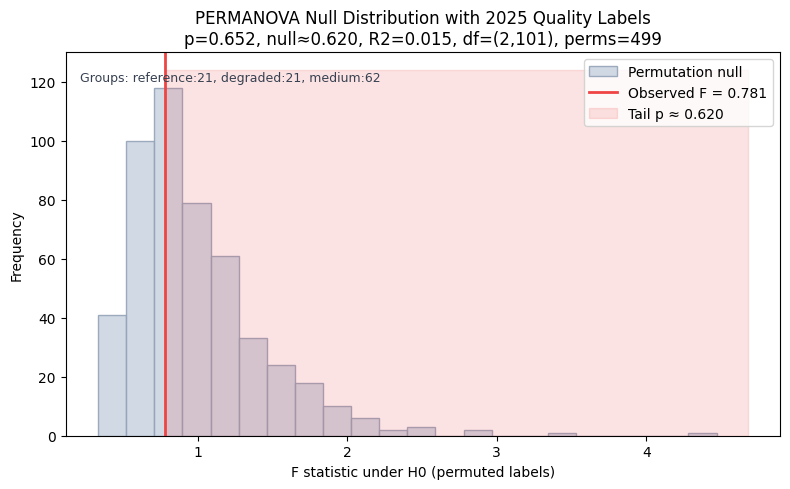

In [14]:
fig_f, ax_f, info_f = plot_permanova_null_distribution(X, 
                                                       labels,
                                                       permutations=499,
                                                       seed=2, 
                                                       title='PERMANOVA Null Distribution with 2025 Quality Labels')
# print(info_f)

## 3) Plot directional one-sided null
Use `plot_directional_null_distribution`. If you didn’t specify labels for reference/degraded, we infer them (e.g., 'reference' vs 'degraded' or 'bottom' vs 'top').

{'statistic': -0.19627387070352517, 'p_value': 0.864, 'p_tail': 0.876, 'mode': 'average', 'reference_label': 'reference', 'degraded_label': 'degraded', 'n_perm': 499, 'top_vars': ['Sb', 'mirex', 'Bi', 'ppDDE', 'ppDDD']}


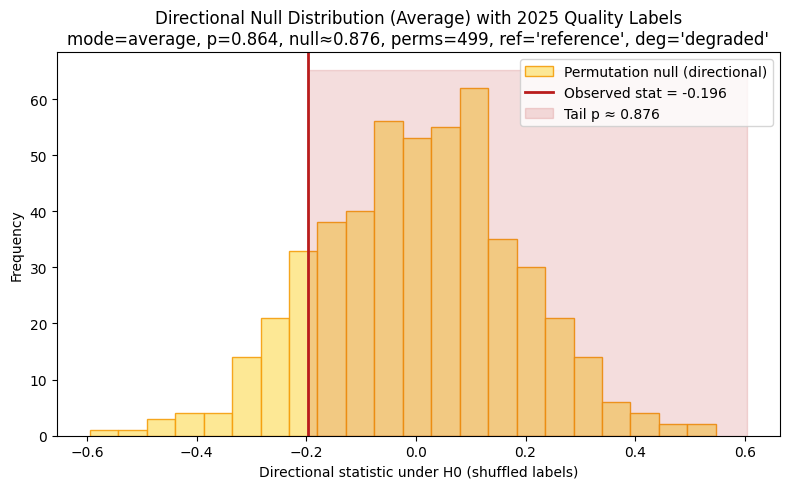

In [15]:
# Infer reference and degraded from labels when not provided
cats = list(pd.Categorical(labels).categories)
ref_candidates = [c for c in cats if str(c).lower().startswith('ref')]
deg_candidates = [c for c in cats if str(c).lower().startswith('deg')]
ref = ref_candidates[0] if ref_candidates else ('bottom' if 'bottom' in cats else min(cats))
deg = deg_candidates[0] if deg_candidates else ('top' if 'top' in cats else max(cats))
fig_d, ax_d, info_d = plot_directional_null_distribution(X,
                        labels,
                        ref,
                        deg,
                        mode='average',
                        permutations=499,
                        standardize=True,
                        var_names=var_names,
                        title = "Directional Null Distribution (Average) with 2025 Quality Labels")
print(info_d)